In [65]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Notebook with EDA and process to Model Selection

## 1) EDA

The goal of the EDA is:
- look for any missing values in the data set
- look for eventual error measurements to be deleted or corrected (we dont necessarily pay very much attention to outliers because they are going to be many for a data set of this size)
- look which predictor variables might be useful to predict bike count 

Before starting the EDA, we remind the reader that the target variable (ie what we are trying to predict) is the variable `log_bike_count`

We first import the original data, set check for missing values and error measurements and then merge it with the external and check no data was lost in the process

In [66]:
pd.set_option("display.precision", 2)  # set precision of outputs of our df

# read the data
df_original = pd.read_parquet(Path("data") / "train.parquet")
df_original.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.85,2.38,0.00
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.85,2.38,0.69
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.85,2.38,0.00
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.85,2.38,1.61
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.85,2.38,2.30


In [67]:
df_original.nunique(axis=0)

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    977
date                         8230
counter_installation_date      22
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                977
dtype: int64

In [68]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455163 entries, 48321 to 928462
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 455163 non-null  category      
 1   counter_name               455163 non-null  category      
 2   site_id                    455163 non-null  int64         
 3   site_name                  455163 non-null  category      
 4   bike_count                 455163 non-null  float64       
 5   date                       455163 non-null  datetime64[ns]
 6   counter_installation_date  455163 non-null  datetime64[ns]
 7   counter_technical_id       455163 non-null  category      
 8   latitude                   455163 non-null  float64       
 9   longitude                  455163 non-null  float64       
 10  log_bike_count             455163 non-null  float64       
dtypes: category(4), datetime64[ns](2), float64(4), i

In [69]:
df_original.describe()

,site_id,bike_count,latitude,longitude,log_bike_count
count,4.55e+05,455163.00,455163.00,455163.00,455163.00
mean,1.05e+08,59.48,48.85,2.35,3.05
std,3.16e+07,87.13,0.02,0.04,1.68
min,1.00e+08,0.00,48.83,2.27,0.00
25%,1.00e+08,4.00,48.84,2.31,1.61
50%,1.00e+08,28.00,48.85,2.35,3.37
75%,1.00e+08,79.00,48.86,2.38,4.38
max,3.00e+08,1275.00,48.89,2.41,7.15


There are 455 163 observations in the training data set and 9 predictor variables. However some of them like `site_name` and `site_id`, or `counter_name` and `counter_id` are redundant and both should not be included in the model. Also,  `site_id` is an int so we should remember it is a categorical variable if we want to use it in our model. <br>
Finally, there are no missing values. 
Let us now perform the merge and check how is the df.

In [70]:
import folium

m = folium.Map(location=df_original[["latitude", "longitude"]].mean(axis=0), zoom_start=13)

for _, row in (
    df_original[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m

We now look at the distribution of the predictor variable.

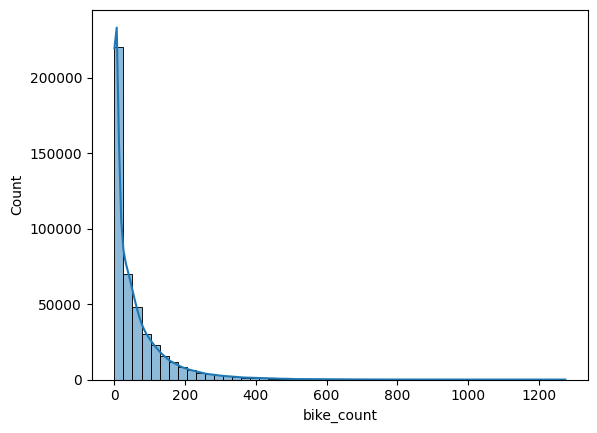

In [71]:
import seaborn as sns


ax = sns.histplot(df_original, x="bike_count", kde=True, bins=50)

Least square loss would not be appropriate to model it since it is designed for normal error distributions. One way to precede would be to transform the variable with a logarithmic transformation,
```py
data['log_bike_count'] = np.log(1 + data['bike_count'])
```

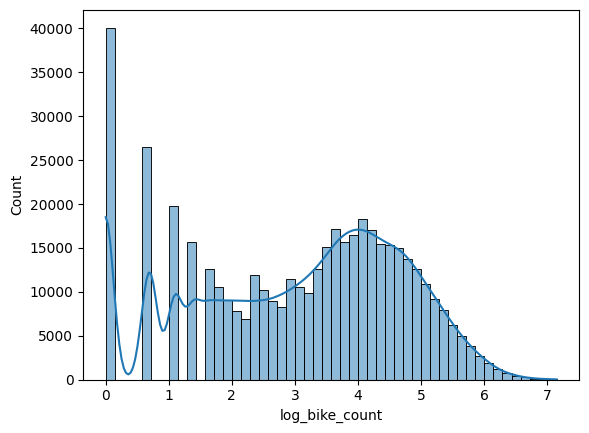

In [72]:
import seaborn as sns


ax = sns.histplot(df_original, x="log_bike_count", kde=True, bins=50)

which has a more pronounced central mode, but is still non symmetric. In the following, **we use `log_bike_count` as the target variable** as otherwise `bike_count` ranges over 3 orders of magnitude and least square loss would be dominated by the few large values. 

In [73]:
file_path = Path("data") / "external_data.csv"
df_ext = pd.read_csv(file_path, parse_dates=["date"])

In [74]:
df_ext.head()

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,numer_sta,date,pmer,tend,cod_tend,dd,...,ctype3,hnuage3,nnuage4,ctype4,hnuage4,hol_scol,hol_bank,quarantine1,quarantine2,christmas_hols
0,0,0,0,0,7149,2021-01-01 00:00:00,100810,80,1,270,...,NaN,NaN,NaN,NaN,NaN,True,True,False,False,True
1,1,1,1,1,7149,2021-01-01 03:00:00,100920,110,3,300,...,NaN,NaN,NaN,NaN,NaN,True,True,False,False,True
2,2,2,2,2,7149,2021-01-01 06:00:00,100950,30,3,290,...,3.0,3000.0,NaN,NaN,NaN,True,True,False,False,True
3,3,3,3,3,7149,2021-01-01 09:00:00,101100,150,2,280,...,NaN,NaN,NaN,NaN,NaN,True,True,False,False,True
4,4,4,4,4,7149,2021-01-01 12:00:00,101110,30,0,50,...,6.0,810.0,NaN,NaN,NaN,True,True,False,False,True


In [75]:
np.unique(df_ext["numer_sta"])

array([7149], dtype=int64)

The weather data comes from one unique station, therefore this column is not needed we can drop it. <br>
The weather station is located in the southern part of Paris (Orly) so the weather data is relevant for Paris.

In [76]:
# remove some unecessary columns
df_ext = df_ext.iloc[:, 3:]

From the head, we already see that some columns seem to have a lot of missing values. We investigate this further. We also check first if there are duplicate rows and if any dates are missing.

In [77]:
df_ext[df_ext.duplicated() == True]

,Unnamed: 0,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,...,ctype3,hnuage3,nnuage4,ctype4,hnuage4,hol_scol,hol_bank,quarantine1,quarantine2,christmas_hols


In [78]:
my_range = pd.date_range(start="2020-09-01", end="2021-10-18")

print(my_range.difference(df_ext["date"]))

DatetimeIndex(['2021-01-17'], dtype='datetime64[ns]', freq=None)


One day is missing in the data set.

There is one duplicate row, we drop it.

In [79]:
df_ext = df_ext.drop_duplicates()

In [80]:
df_ext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3322 entries, 0 to 3321
Data columns (total 65 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Unnamed: 0      3322 non-null   int64         
 1   numer_sta       3322 non-null   int64         
 2   date            3322 non-null   datetime64[ns]
 3   pmer            3322 non-null   int64         
 4   tend            3322 non-null   int64         
 5   cod_tend        3322 non-null   int64         
 6   dd              3322 non-null   int64         
 7   ff              3322 non-null   float64       
 8   t               3322 non-null   float64       
 9   td              3322 non-null   float64       
 10  u               3322 non-null   int64         
 11  vv              3322 non-null   int64         
 12  ww              3322 non-null   int64         
 13  w1              3315 non-null   float64       
 14  w2              3312 non-null   float64       
 15  n   

In [81]:
print(df_ext.isnull().sum()[df_ext.isnull().sum() > 0])
print(
    f"there are {df_ext.isnull().sum()[df_ext.isnull().sum()>0].shape[0]} columns with at least 1 missing values "
)

w1              7
w2             10
n             156
nbas            5
hbas          453
cl            413
cm           1381
ch           1644
niv_bar      3322
geop         3322
tend24         10
tn12         2492
tn24         3322
tx12         2492
tx24         3322
tminsol      3321
sw           3322
tw           3322
raf10          10
etat_sol       52
ht_neige       49
ssfrai        445
perssfrai     445
rr1             9
rr3             6
rr6            16
rr12           22
rr24           24
phenspe1     3322
phenspe2     3322
phenspe3     3322
phenspe4     3322
nnuage1       449
ctype1        798
hnuage1       455
nnuage2      1627
ctype2       1879
hnuage2      1627
nnuage3      2704
ctype3       2852
hnuage3      2704
nnuage4      3280
ctype4       3235
hnuage4      3280
dtype: int64
there are 44 columns with at least 1 missing values 


We have 44 columns with missing values.

Hence, we see that most columns have missing values and from the output, some columns have no non NA values! <br>
We drop the columns that have more than 10% missing values first as we are unlikely to be able to get interesting predictions with that little amount of data.


In [82]:
n_rows = df_ext.shape[0]

columns_to_drop = (df_ext.isnull().sum() / n_rows)[
    (df_ext.isnull().sum() / n_rows) > 0.1
].index

df_ext = df_ext.drop(columns=columns_to_drop)

Let us check now the missing values again.

In [83]:
# df_merge_ext[df_merge_ext.isnull().sum()>0]
col_with_miss_values = df_ext.isnull().sum()[df_ext.isnull().sum() > 0].index
print(col_with_miss_values)

Index(['w1', 'w2', 'n', 'nbas', 'tend24', 'raf10', 'etat_sol', 'ht_neige',
       'rr1', 'rr3', 'rr6', 'rr12', 'rr24'],
      dtype='object')


There are 13 columns with missing values. How are these values missing, are they MCAR, MAR, or is there any pattern in the missing values?


We plot the missing values against time.

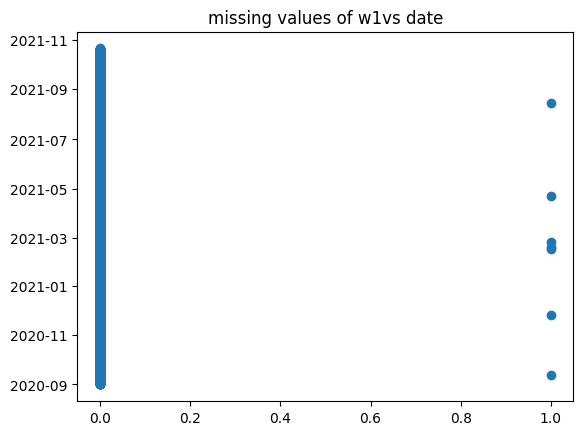

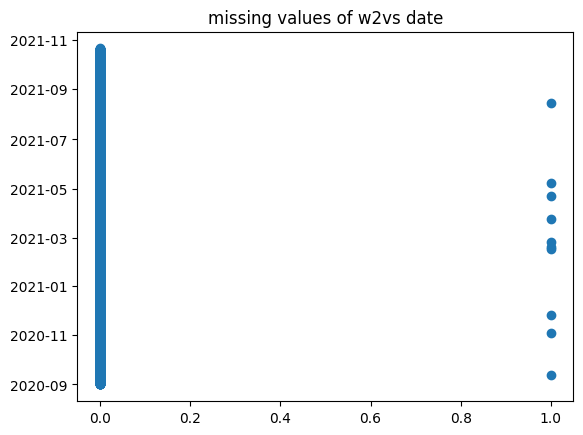

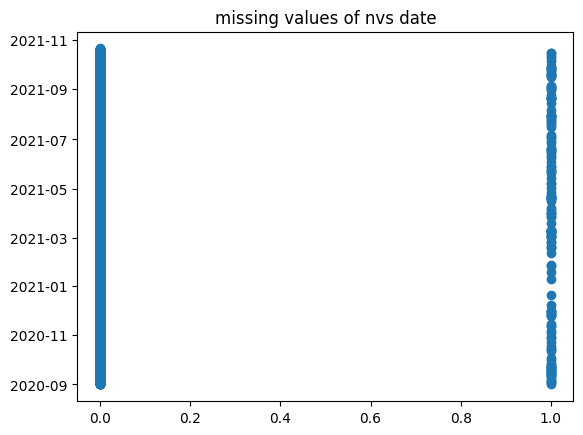

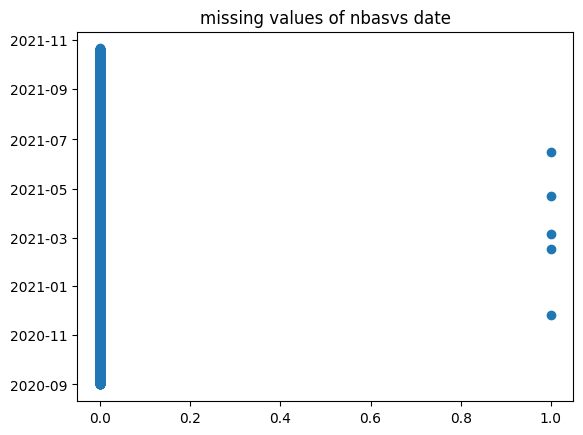

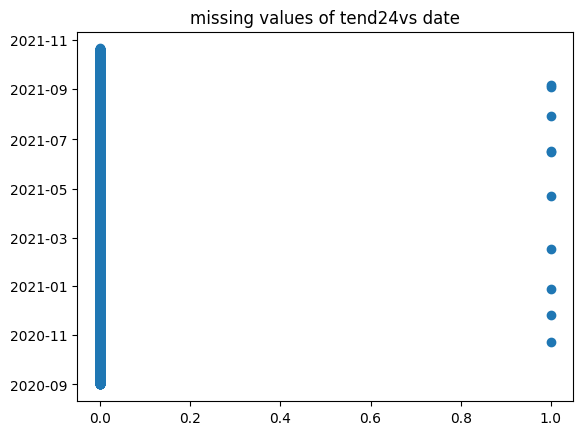

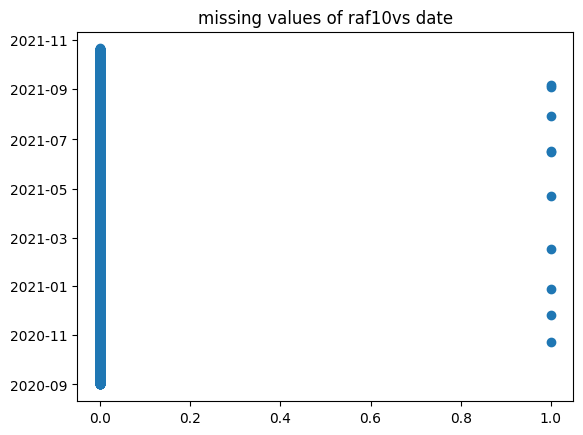

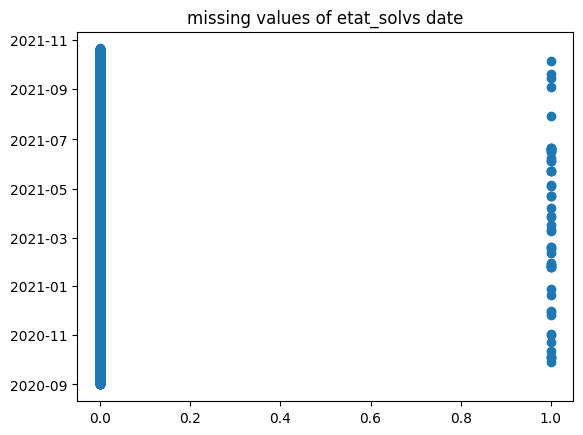

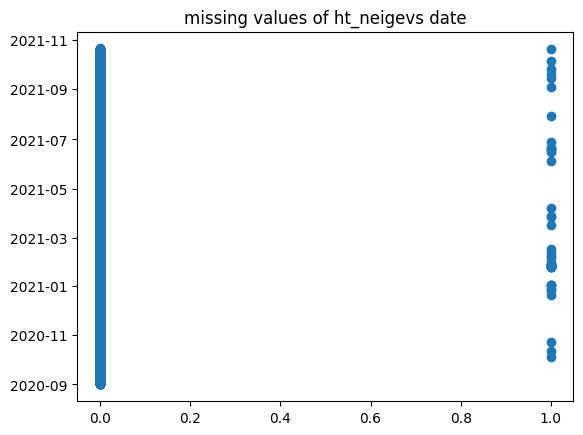

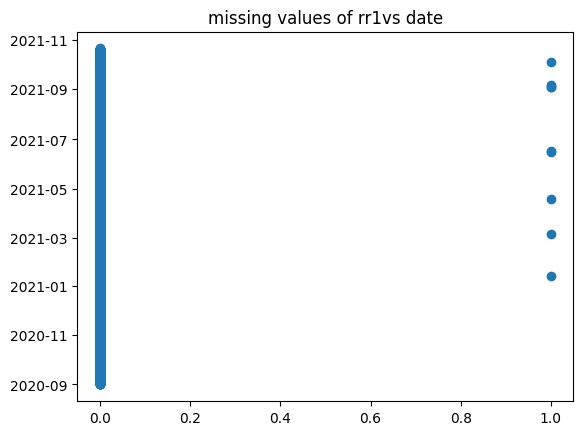

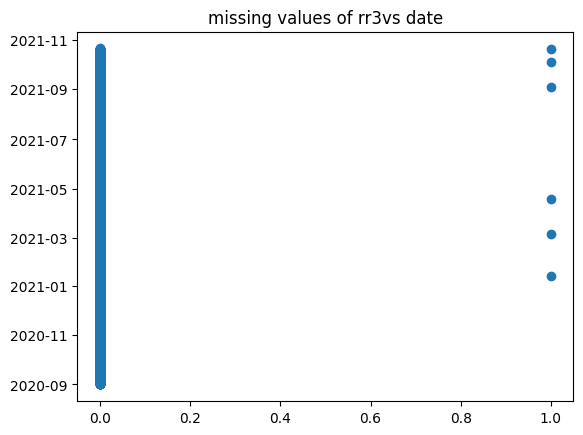

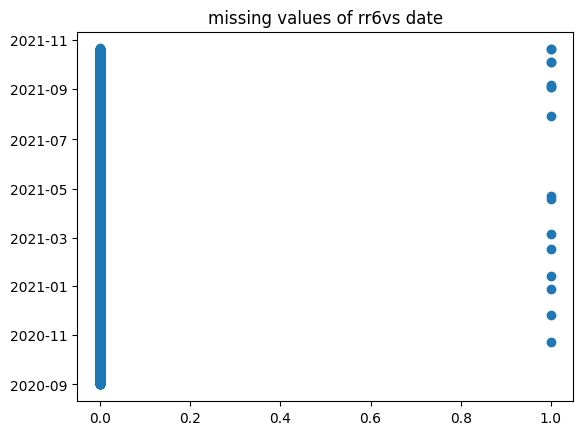

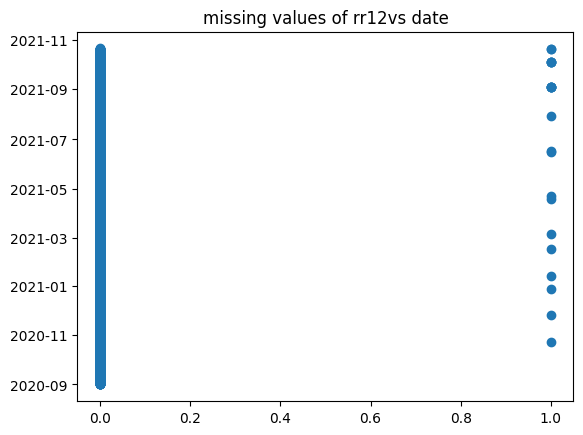

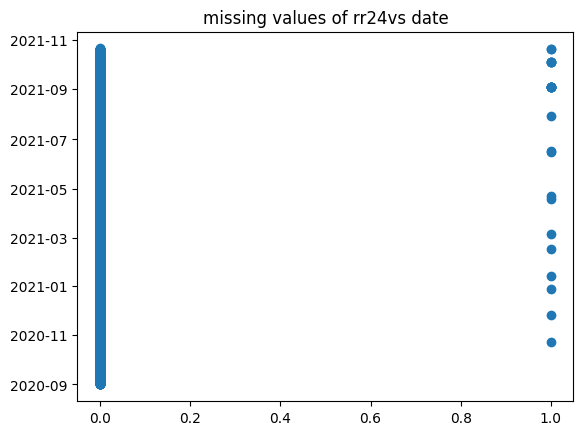

In [84]:
for el in col_with_miss_values:
    plt.scatter(df_ext[el].isnull(), df_ext["date"])
    plt.title("missing values of " + el + "vs date")
    plt.show()

In [85]:
df_ext.isnull().sum()[df_ext.isnull().sum() > 0]

w1            7
w2           10
n           156
nbas          5
tend24       10
raf10        10
etat_sol     52
ht_neige     49
rr1           9
rr3           6
rr6          16
rr12         22
rr24         24
dtype: int64

As we have noted that most missing values are not in series we can use linear interpolation to recover the missing values. A limit to fill 4 consecutive NANs is needed to fill all the missing values, however a limit of 1 fills already a lot of the values meaning we don't loose too much weather precision. <br>
In linear interpolation, the estimated point is assumed to lie on the line joining the nearest points to the left and right. <br>
The code variables need to use ffil=pad to not create new codes due to interpolation.

In [86]:
linear_cols = [
    "n",
    "nbas",
    "tend24",
    "raf10",
    "ht_neige",
    "rr1",
    "rr3",
    "rr6",
    "rr12",
    "rr24",
]
for col in linear_cols:
    df_ext[col] = df_ext[col].interpolate(
        method="linear", limit=4, limit_direction="both", axis=0
    )
pad_cols = ["w1", "w2", "etat_sol"]
for col in pad_cols:
    df_ext[col] = df_ext[col].interpolate(
        method="pad", limit=4, limit_direction="forward", axis=0
    )

In [87]:
df_ext.isnull().sum()[df_ext.isnull().sum() > 0]

Series([], dtype: int64)

In [88]:
# merge on date to obtain the full data set.
df_merge_ext = pd.merge_asof(
    df_original.sort_values("date"), df_ext.sort_values("date"), on="date"
)

In [89]:
df_merge_ext.isnull().sum()[df_merge_ext.isnull().sum() > 0]

Series([], dtype: int64)

In [90]:
df_merge_ext.columns

Index(['counter_id', 'counter_name', 'site_id', 'site_name', 'bike_count',
       'date', 'counter_installation_date', 'counter_technical_id', 'latitude',
       'longitude', 'log_bike_count', 'Unnamed: 0', 'numer_sta', 'pmer',
       'tend', 'cod_tend', 'dd', 'ff', 't', 'td', 'u', 'vv', 'ww', 'w1', 'w2',
       'n', 'nbas', 'pres', 'tend24', 'raf10', 'rafper', 'per', 'etat_sol',
       'ht_neige', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'hol_scol', 'hol_bank',
       'quarantine1', 'quarantine2', 'christmas_hols'],
      dtype='object')

Aside from the weather data, boolean features for the school and bank holidays were added as it seems reasonnable to assume a change in bike counts on those days. The Covid quarantine periods were added as well.

### Adding some extra features due to EDA

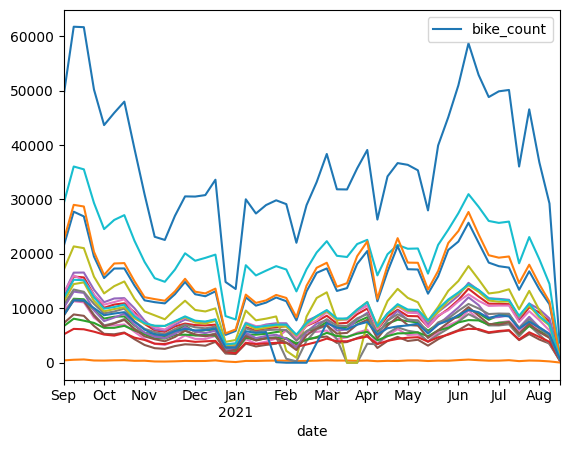

In [91]:
mask = (
    df_original["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"
)  # & (data["date"] < "2021-01-01") & (data["date"] >= "2021-01-01")
ax = (
    df_original[mask]
    .groupby(pd.Grouper(freq="1w", key="date"))[["bike_count"]]
    .sum()
    .plot()
)
i = 0
for name in df_original["counter_name"].unique().to_list():
    if i == 20:
        break
    i += 1
    mask = df_original["counter_name"] == name
    df_original[mask].groupby(pd.Grouper(freq="1w", key="date"))[
        ["bike_count"]
    ].sum().plot(ax=ax, legend=False)

In [92]:
df_original[mask].sample(10)

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
404458,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,65.0,2021-01-10 14:00:00,2018-12-07,Y2H19070373,48.84,2.33,4.19
408034,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,5.0,2021-06-06 01:00:00,2018-12-07,Y2H19070373,48.84,2.33,1.79
404097,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,0.0,2021-02-10 18:00:00,2018-12-07,Y2H19070373,48.84,2.33,0.00
404084,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,99.0,2021-04-23 16:00:00,2018-12-07,Y2H19070373,48.84,2.33,4.61
403395,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,0.0,2021-01-11 04:00:00,2018-12-07,Y2H19070373,48.84,2.33,0.00
406369,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,60.0,2021-03-30 10:00:00,2018-12-07,Y2H19070373,48.84,2.33,4.11
403007,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,68.0,2021-03-09 13:00:00,2018-12-07,Y2H19070373,48.84,2.33,4.23
399512,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,47.0,2020-10-12 05:00:00,2018-12-07,Y2H19070373,48.84,2.33,3.87
400175,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,4.0,2020-11-07 23:00:00,2018-12-07,Y2H19070373,48.84,2.33,1.61
401690,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,28.0,2021-01-12 20:00:00,2018-12-07,Y2H19070373,48.84,2.33,3.37


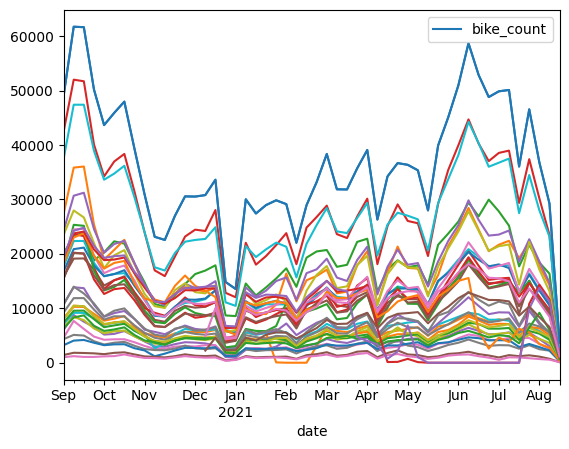

In [93]:
mask = (
    df_original["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"
)  # & (data["date"] < "2021-01-01") & (data["date"] >= "2021-01-01")
ax = (
    df_original[mask]
    .groupby(pd.Grouper(freq="1w", key="date"))[["bike_count"]]
    .sum()
    .plot()
)
for i in range(20, len(df_original["counter_name"].unique().to_list())):
    name = df_original["counter_name"].unique().to_list()[i]
    # print(name)
    mask = df_original["counter_name"] == name
    df_original[mask].groupby(pd.Grouper(freq="1w", key="date"))[
        ["bike_count"]
    ].sum().plot(ax=ax, legend=False)

By plotting the counts over the weeks we can observe a strong general drop due to the Christmas holiday. We will ad a boolean variable for it.

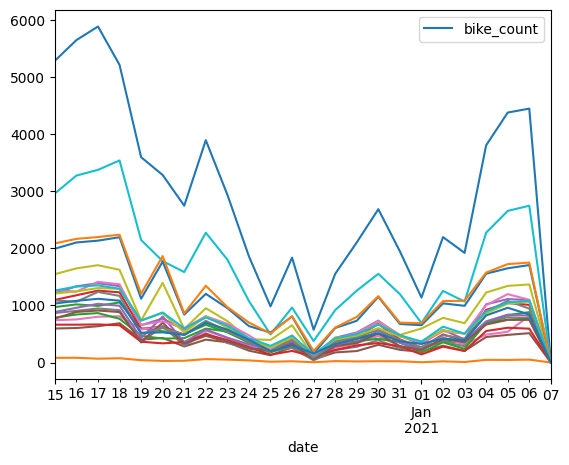

In [94]:
mask = (
    (df_original["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (df_original["date"] >= "2020-12-15")
    & (df_original["date"] <= "2021-01-07")
)
ax = (
    df_original[mask]
    .groupby(pd.Grouper(freq="1d", key="date"))[["bike_count"]]
    .sum()
    .plot()
)
i = 0
for name in df_original["counter_name"].unique().to_list():
    if i == 20:
        break
    i += 1
    mask = (
        (df_original["counter_name"] == name)
        & (df_original["date"] >= "2020-12-15")
        & (df_original["date"] <= "2021-01-07")
    )
    df_original[mask].groupby(pd.Grouper(freq="1d", key="date"))[
        ["bike_count"]
    ].sum().plot(ax=ax, legend=False)

We can clearly see a drop in the christmas holidays in Paris : samedi 18 décembre 2021 au lundi 3 janvier 2022.

In [95]:
df_predictors = df_merge_ext.iloc[:, 11:]

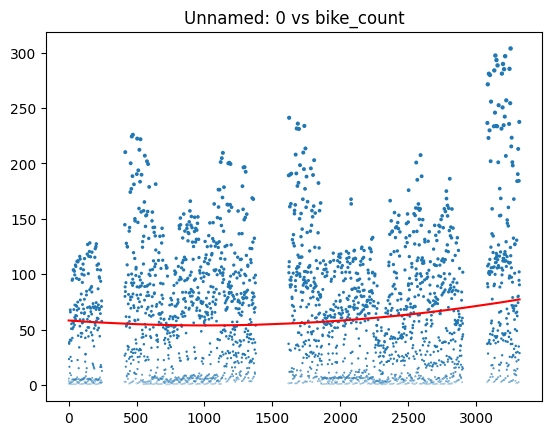

c:\Users\mathi\anaconda3\envs\bikes-ramp\lib\site-packages\IPython\core\interactiveshell.py:3378: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


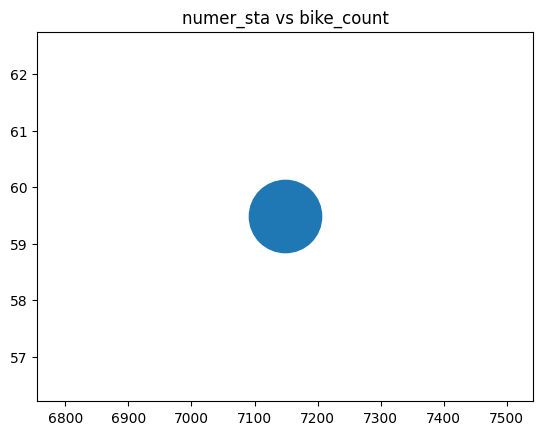

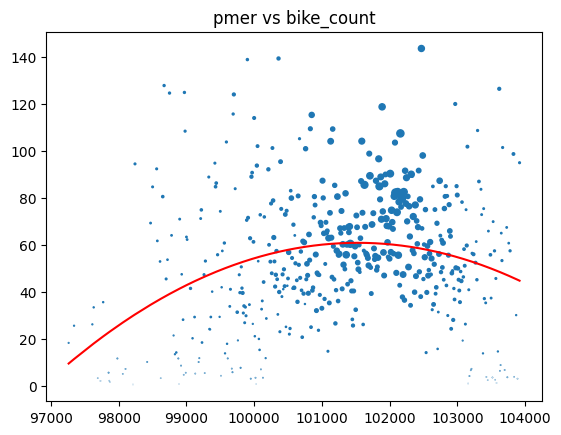

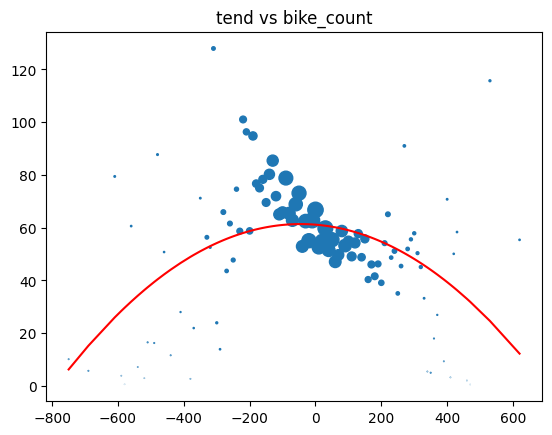

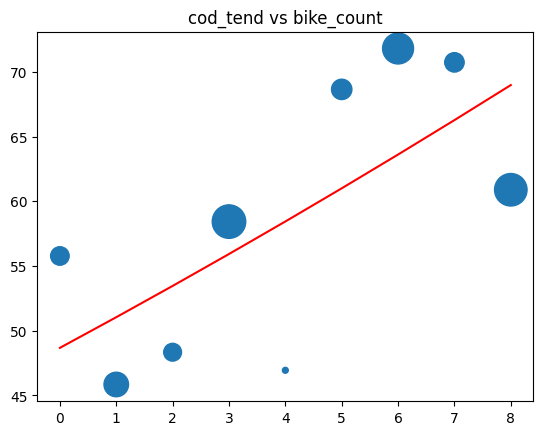

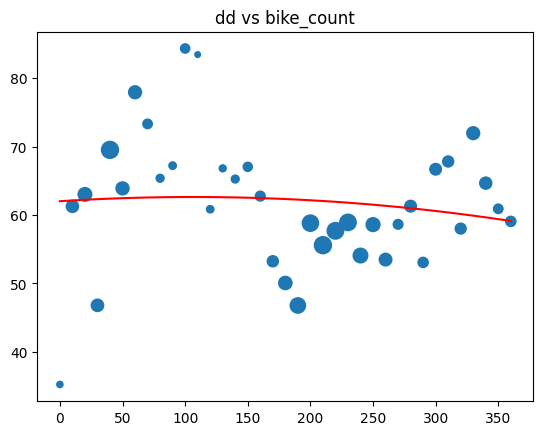

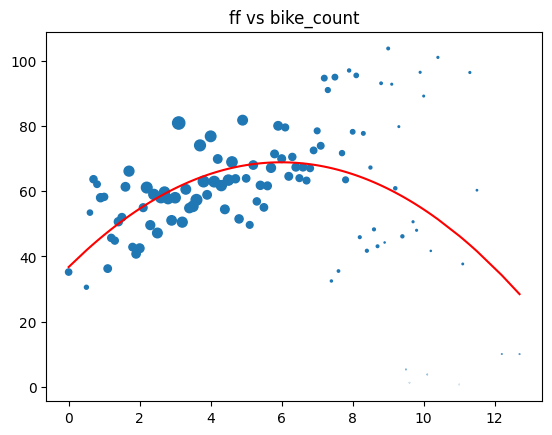

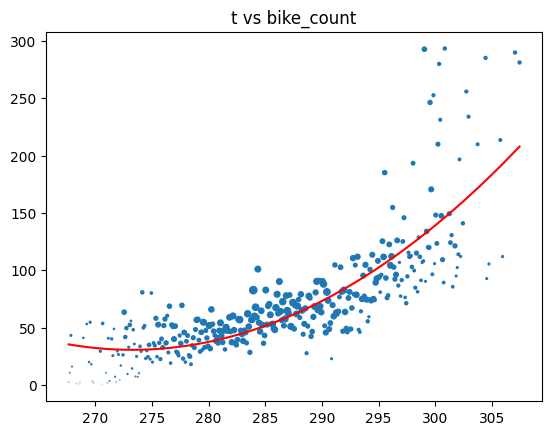

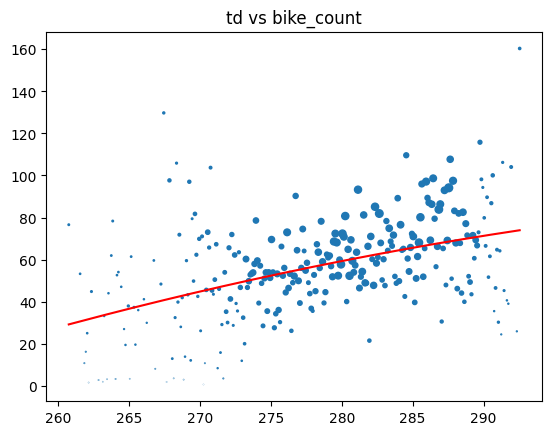

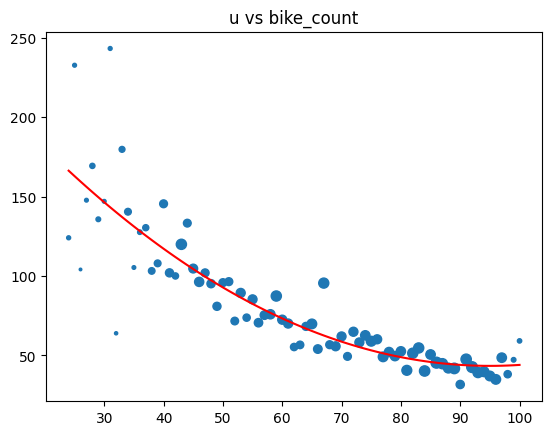

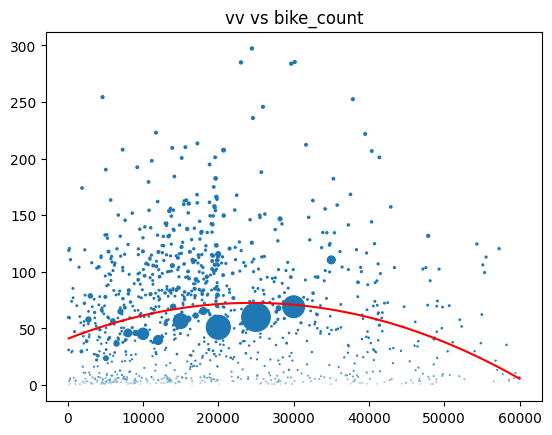

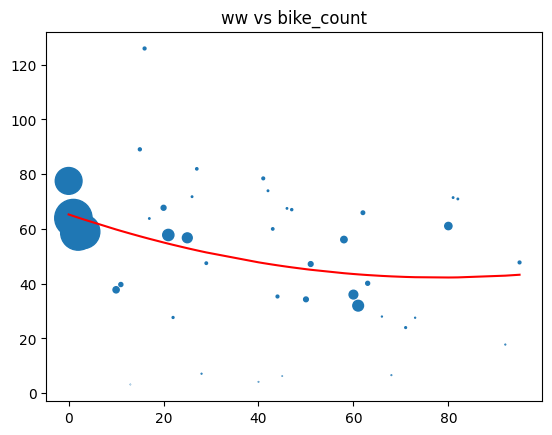

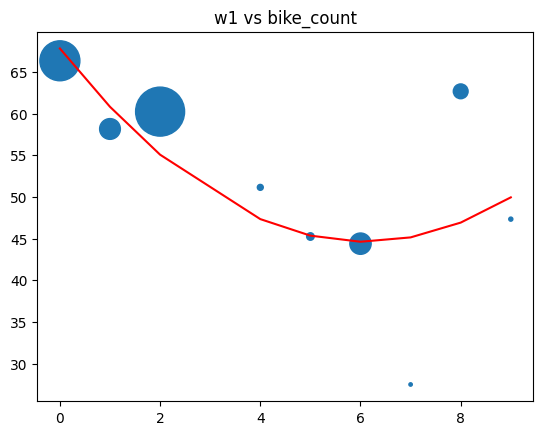

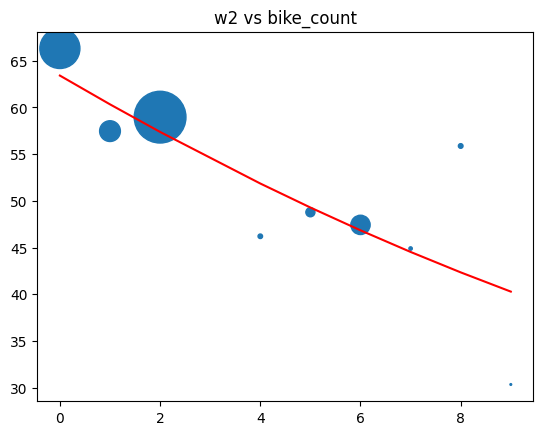

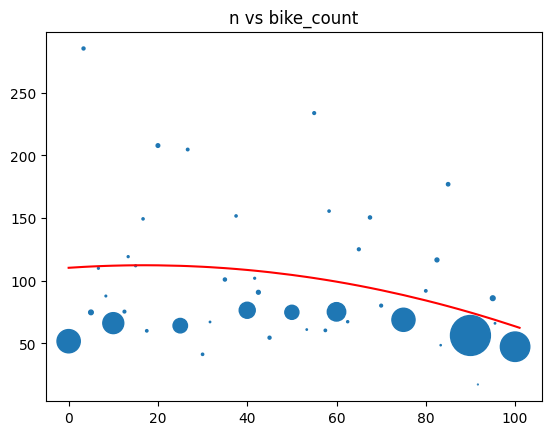

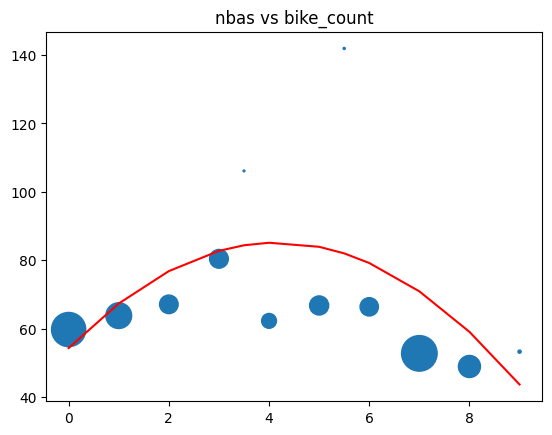

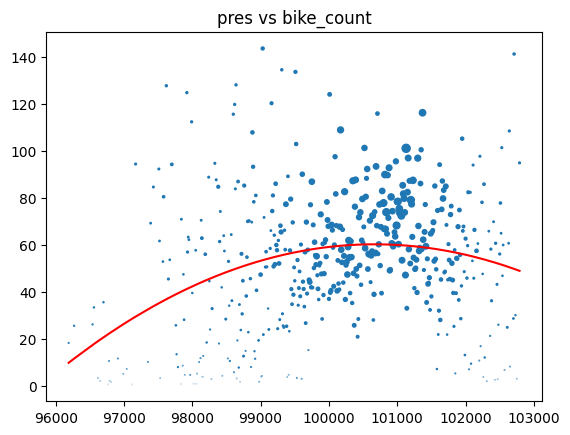

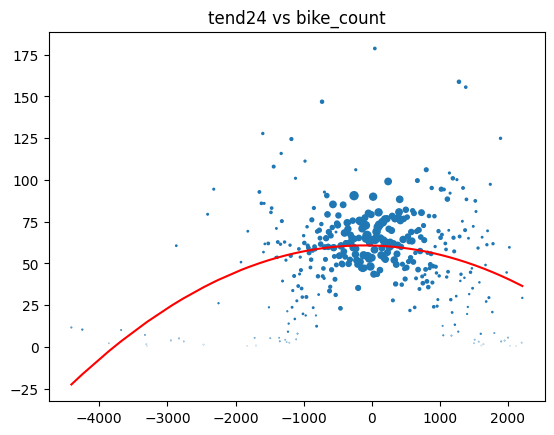

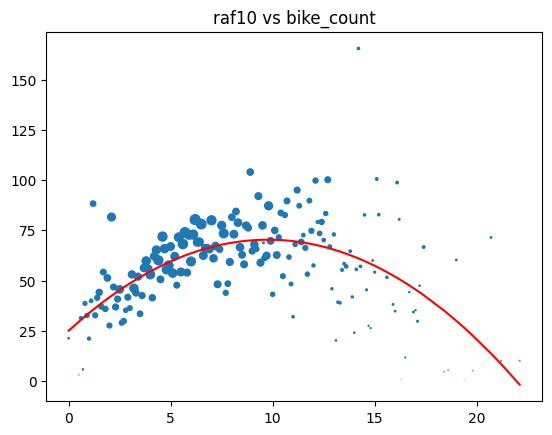

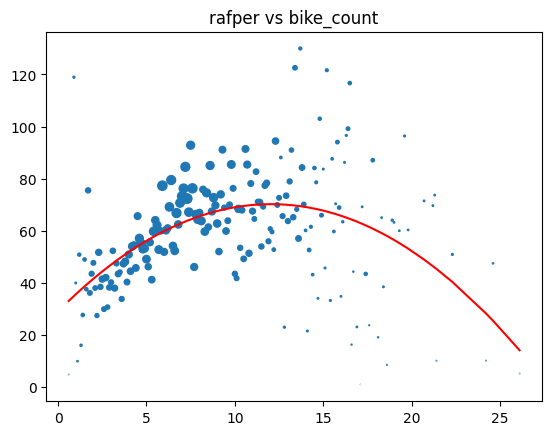

c:\Users\mathi\anaconda3\envs\bikes-ramp\lib\site-packages\IPython\core\interactiveshell.py:3378: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


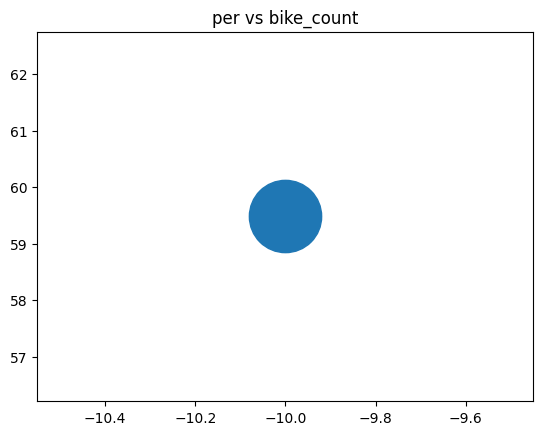

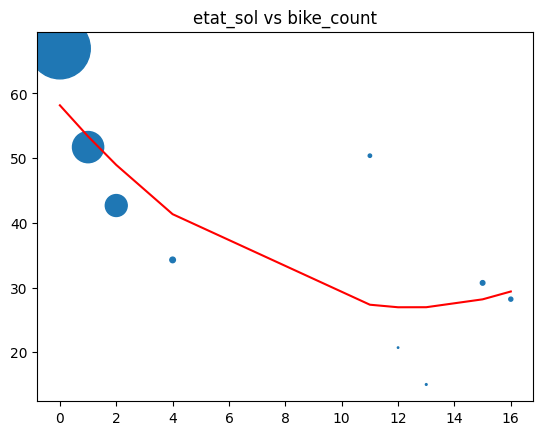

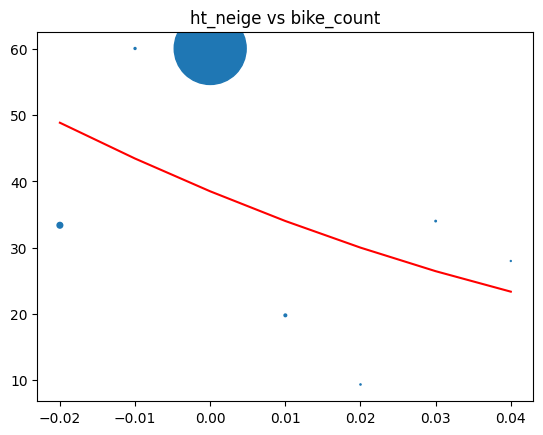

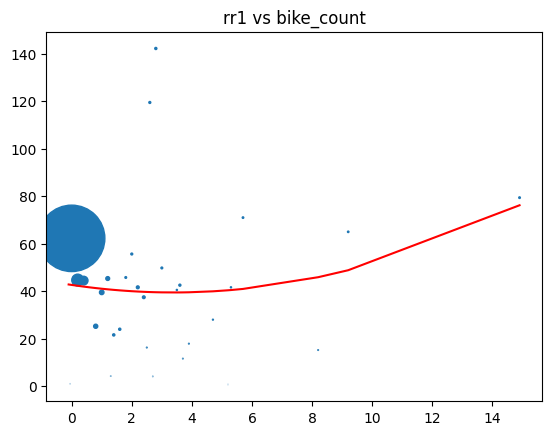

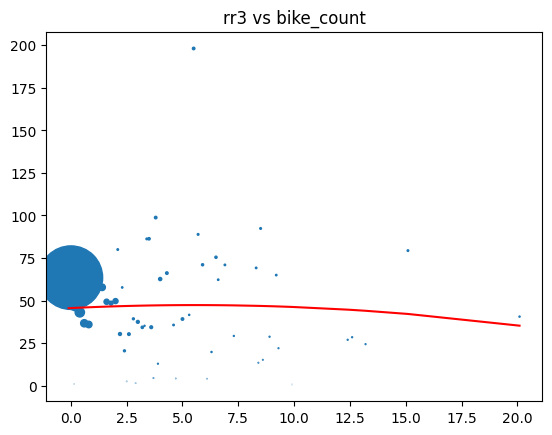

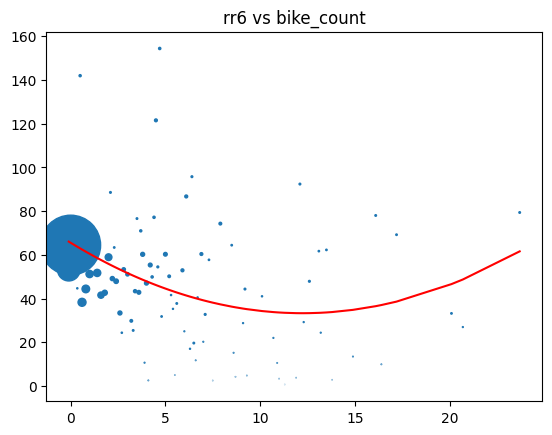

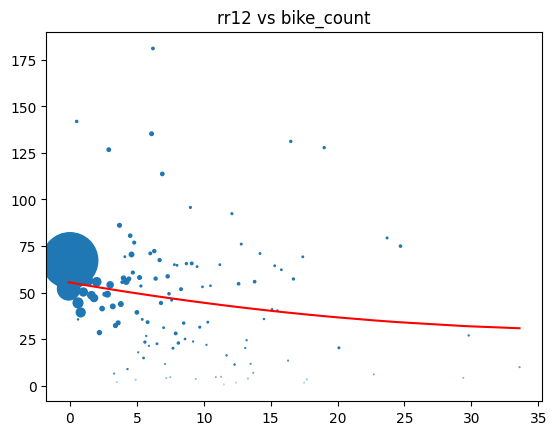

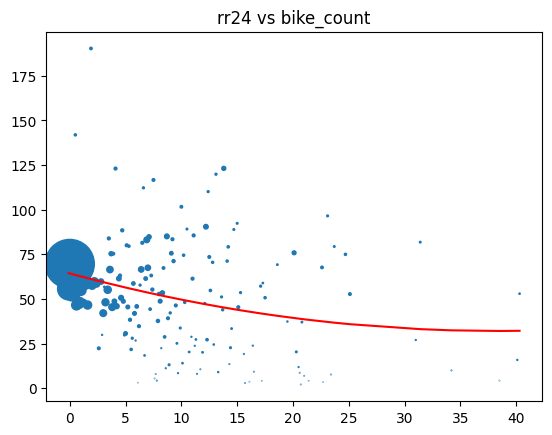

c:\Users\mathi\anaconda3\envs\bikes-ramp\lib\site-packages\IPython\core\interactiveshell.py:3378: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


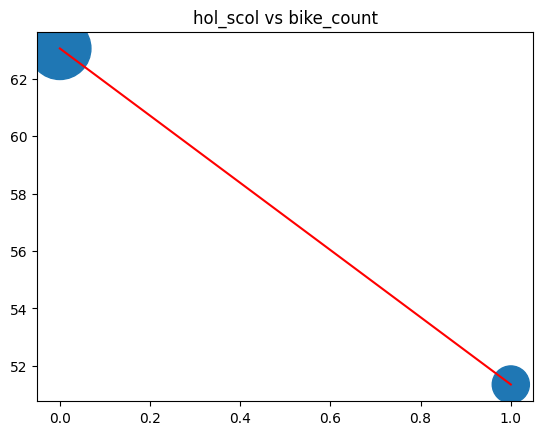

c:\Users\mathi\anaconda3\envs\bikes-ramp\lib\site-packages\IPython\core\interactiveshell.py:3378: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


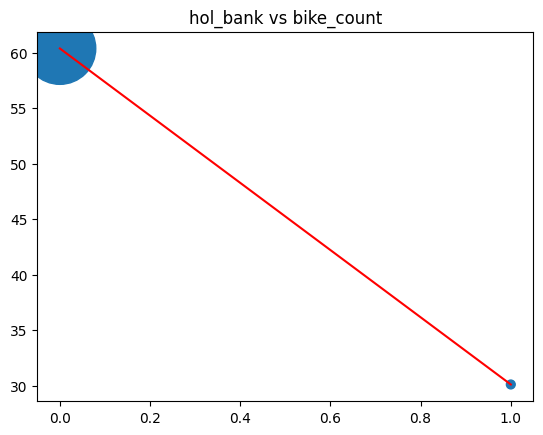

c:\Users\mathi\anaconda3\envs\bikes-ramp\lib\site-packages\IPython\core\interactiveshell.py:3378: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


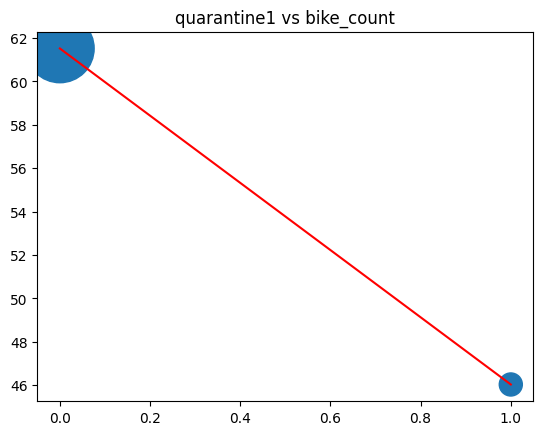

c:\Users\mathi\anaconda3\envs\bikes-ramp\lib\site-packages\IPython\core\interactiveshell.py:3378: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


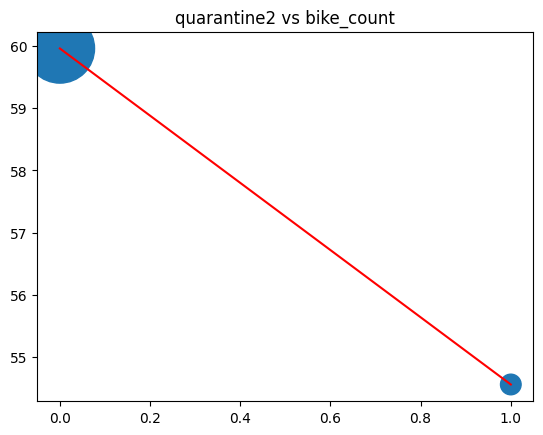

c:\Users\mathi\anaconda3\envs\bikes-ramp\lib\site-packages\IPython\core\interactiveshell.py:3378: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


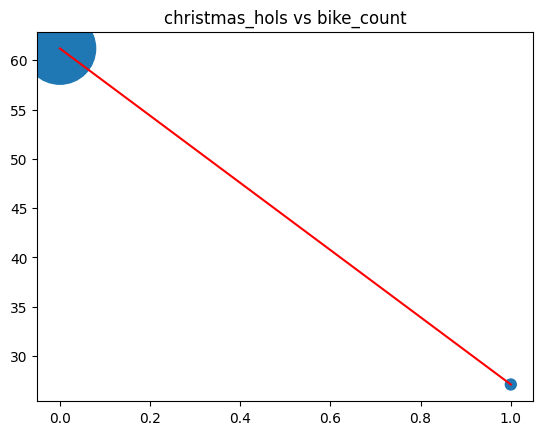

In [96]:
df_mask = df_merge_ext[
    df_merge_ext["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"
]

for el in df_predictors.columns:
    plt.title(str(el) + " vs " + "bike_count")

    # df_plot = df_mask.groupby(pd.Grouper(key=el))[["bike_count"]].mean().sort_index()
    # df_plot1 = df_mask.groupby(pd.Grouper(key=el))[["bike_count"]].sum().sort_index()

    df_plot = (
        df_merge_ext.groupby(pd.Grouper(key=el))[["bike_count"]].mean().sort_index()
    )
    df_plot1 = (
        df_merge_ext.groupby(pd.Grouper(key=el))[["bike_count"]].sum().sort_index()
    )

    plt.scatter(df_plot.index, df_plot["bike_count"], s=df_plot1["bike_count"] / 10000)

    # coefficients for second order regression line
    m1, m, b = np.polyfit(df_plot.index, df_plot["bike_count"], 2)

    # use red as color for regression line
    plt.plot(
        df_plot.index, m1 * df_plot.index**2 + m * df_plot.index + b, color="red"
    )
    plt.show()

We observe that many predictors do not have linear relationship with the output variable and therefore, Ridge regression would be a poor choice of model if we were not transforming the predictors. Moreover, we see with these plots that the most interesting predictors are: `hol_bank` with a mean for bike_count of 30 for True and 60 for False, `u`, `cod_tend`and `t`have strong linear relationship with `bike_count`and therefore should be included in the model. `quarantine1`is also much better than `quarantine2`to predict `bike_count`. The rest of the predictors should be tested, but with these plots we already have a baseline for which predictors should be included. <br>
The predictors we should maybe not include are:  `rr3`,`rr1`,`per` because they do not dicriminate `bike_count`.

All counts :
Good: `cod_tend`, `ff`, `t`, `u`, `etat_sol`,`hol_scol`,`hol_bank`,`quarantine1`,`quarantine2`,`christmas_hols` <br>
Ok: `pmer`, `tend`,`td`, `ww`, `ww`,`w1`,`w1`,`w2`,`nbas`,`raf10`,`rafper`, `ht_neige` <br>
Bad:`dd`, `tend`,`dd`,`vv`,`n`,`pres`,`tend24`, `rr1` , `rr3` , `rr6` , `rr12`, `rr24` <br>

Changes when only first counter:
Good:  <br>
Ok:  <br>
Bad: `ww`, <br>

`pmer` = pressure <br>
`tend` = pressure variance in 3 hours <br>
`cod_tend` =  the difference between the atmospheric pressure at the time of observation and the atmospheric pressure three hours earlier <br>
`dd` = wind direction <br>
`ff` = wind speed <br>
`t` = temp <br>
`td` = dew point (affects rain) <br>
`u` = humidity <br>
`vv` = hor vis <br>
`ww` = present time (actually folowing the code it present weather) see https://www.jodc.go.jp/data_format/weather-code.html <br>
`w1` = Past weather http://www.weathergraphics.com/fcstbook/codes.pdf <br>
`w2` = Past weather http://www.weathergraphics.com/fcstbook/codes.pdf <br>
`n` = total cloudiness <br>
`nbas` = lower cloudiness <br>
`pres` = ?? presure <br>
`tend24` = pressure variations in 24hours <br>
`raf10` = gusts over the last 10min <br>
`rafper` = gusts over a period <br>
`per` = period of the burst <br> #only one value so not interesting
`etat_sol` =  https://artefacts.ceda.ac.uk/badc_datadocs/surface/code.html <br>
`ht_neige` = hight of snow <br>
`rr1` = prec in last hour <br>
`rr3` = prec in last 3 hours <br>
`rr6` = prec in last 6 hours <br>
`rr12` = prec in last 12 hours <br>
`rr24` = prec in last 24 hours <br>
`hol_scol` = <br>
`hol_bank` = <br>
`quarantine1` = <br>
`quarantine2` = <br>
`christmashol` = <br>

### functions we created to test many models easily.

In [97]:
def _merge_external_data(X):
    columns_in_merged = [
        "date",
        "cod_tend",
        "ff",
        "t",
        "u",
        "etat_sol",
        "hol_scol",
        "hol_bank",
        "quarantine1",
        "quarantine2",
        "christmas_hols",
        "pmer",
        "tend",
        "td",
        "ww",
        "w1",
        "w2",
        "nbas",
        "raf10",
        "rafper",
        "ht_neige",
    ]
    file_path = Path("data") / "external_data.csv"
    df_ext = pd.read_csv(file_path, parse_dates=["date"])

    linear_cols = [
        "n",
        "nbas",
        "tend24",
        "raf10",
        "ht_neige",
        "rr1",
        "rr3",
        "rr6",
        "rr12",
        "rr24",
    ]
    for col in linear_cols:
        df_ext[col] = df_ext[col].interpolate(
            method="linear", limit=4, limit_direction="both", axis=0
        )
    pad_cols = ["w1", "w2", "etat_sol"]
    for col in pad_cols:
        df_ext[col] = df_ext[col].interpolate(
            method="pad", limit=4, limit_direction="forward", axis=0
        )

    X = X.copy()
    # When using merge_asof left frame need to be sorted
    X["orig_index"] = np.arange(X.shape[0])

    X = pd.merge_asof(  # , "nbas" , "raf10"
        X.sort_values("date"),
        df_ext[columns_in_merged].sort_values("date").dropna(),
        on="date",
        direction="nearest",
    )  # check result without direction=nearest
    # Sort back to the original order
    X = X.sort_values("orig_index")
    del X["orig_index"]
    return X


def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    X.loc[:, "weekend"] = X["weekday"] > 4

    X["sin_hours"] = np.sin(2 * np.pi * X["hour"] / 24)
    X["cos_hours"] = np.cos(2 * np.pi * X["hour"] / 24)

    X["sin_mnth"] = np.sin(2 * np.pi * X["month"] / 12)
    X["cos_mnth"] = np.cos(2 * np.pi * X["month"] / 12)

    return X.drop(columns=["date"])

First we create a function to easily get the different features we want to test.
We get:
- the features that do not need to be preprocessed 
- the categorical features that need 1-0 encoding

In [98]:
# function to get the features that do not need to be processed
def get_passthrough(date="transformed_date", list_of_temp=[]):
    """function to get the features that will not be transformed at the prepocessing stage

    Args:
        date (str): "both_date": select all the date features
                    "original_date": selecte date without sin transformed
                    "transformed_date": select date with sin-cos transformation

        list_of_temp (list): list of features (no date) that will not be transformed

    Returns:
        _type_: features to not be transformed
    """
    pass_through_cols = []

    if "original_date" == date:
        pass_through_cols = ["year", "month", "day", "weekday", "hour"]

    if "both_date" == date:
        pass_through_cols = [
            "year",
            "month",
            "day",
            "weekday",
            "hour",
            "sin_hours",
            "cos_hours",
            "sin_mnth",
            "cos_mnth",
        ]

    if "transformed_date" == date:
        pass_through_cols = [
            "year",
            "day",
            "weekday",
            "sin_mnth",
            "cos_mnth",
            "sin_hours",
            "cos_hours",
        ]

    if "transformed_date_no_year" == date:
        pass_through_cols = [
            "day",
            "weekday",
            "sin_mnth",
            "cos_mnth",
            "sin_hours",
            "cos_hours",
        ]

    if "transformed_date_no_day" == date:
        pass_through_cols = [
            "year",
            "weekday",
            "sin_mnth",
            "cos_mnth",
            "sin_hours",
            "cos_hours",
        ]
    if "transformed_date_no_year_no_day" == date:
        pass_through_cols = [
            "weekday",
            "sin_mnth",
            "cos_mnth",
            "sin_hours",
            "cos_hours",
        ]
    for el in list_of_temp:
        pass_through_cols.append(el)

    return pass_through_cols

In [99]:
def get_estimator(pass_through_cols, categorical_cols, regressor=XGBRegressor()):

    # define the encoders
    categorical_encoder = OneHotEncoder(handle_unknown="ignore")
    date_encoder = FunctionTransformer(_encode_dates)

    # define the transformation of data before using regressor
    if pass_through_cols != []:
        preprocessor = ColumnTransformer(
            [
                ("cat", categorical_encoder, categorical_cols),
                ("std_scaler", StandardScaler(), pass_through_cols),
                # ("passthrough", "passthrough", pass_through_cols)
            ],
        )

    else:
        preprocessor = ColumnTransformer(
            [
                ("cat", categorical_encoder, categorical_cols),
                ("std_scaler", StandardScaler(), pass_through_cols),
                # ("passthrough", "passthrough", pass_through_cols)
            ],
        )
    pipe = make_pipeline(
        FunctionTransformer(_merge_external_data, validate=False),
        date_encoder,
        preprocessor,
        regressor,
    )

    return pipe

In [100]:
import problem

In [101]:
def test_model(
    pass_throughs_col,
    categorical_cols,
    regressor=XGBRegressor(max_depth=4, subsample=0.8),
):
    """test a model given the features and the regressor and output the prediction on the test data set and the scores on train and test

    Args:
        pass_throughs_col (list): list of features not to be transform during pre-processing step
        categorical_cols (list): columns to be one hot encoded
        regressor (regressor to use in our model, optional): scikit compatible function. Defaults to XGBRegressor().

    Returns:
        array,float,float: the prediction on the test set, the score on the training set, the score on the testing set
    """
    X_train, y_train = problem.get_train_data()
    X_test, y_test = problem.get_test_data()
    model = get_estimator(pass_throughs_col, categorical_cols, regressor)
    model.fit(X_train, y_train)

    cv = TimeSeriesSplit(n_splits=6)

    scores = cross_val_score(
        model, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
    )
    return (
        model.predict(X_test),
        round(mean_squared_error(y_train, model.predict(X_train)), 3),
        round(-scores.mean(), 3),
        round(-scores.std(), 3),
        round(mean_squared_error(y_test, model.predict(X_test), squared=False), 3),
    )

Warning: DONT RUN THE MODEL SELECTION PART AS WE TEST DIFFERENT MODELS AND IT WILL TAKE A LOT OF TIME TOO RUN

## 2) Model Selection

Now that we have our functions to test different models quickly, we are going to try some different models using linear regression and Xgboost and compare the RMSE. Because XGboost tends to overfitt, we are going to limit the complexity of our model to an arbitrary threshold.<br>
We are going to test:
- the minimum model with date not transformed and no external data added
- min model with date transformed (we dont use both dates as it is redundant)
- min model with weather 
- min model with quarantine 
- min model with holidays

Then we are going to try different combination of the above models.

In [ ]:
# first test the min models for different regressors
from sklearn.neural_network import MLPRegressor

estimator = [
    RidgeCV(),
    XGBRegressor(max_depth=4, subsample=0.8),
    MLPRegressor(hidden_layer_sizes=(16, 8), max_iter=300),
    MLPRegressor(hidden_layer_sizes=(8, 4), alpha=0.001, max_iter=300),
]
date_no_transformed = get_passthrough("original_date")
category_base = ["counter_name", "site_name"]
# min model
for regressors in estimator:
    _, score_train, cv_score, std, score_test = test_model(
        [], date_no_transformed + category_base, regressors
    )
    print(f"For model with {regressors}:")
    print(f"the categorical predictors are: {date_no_transformed + category_base}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

As can be seen a simple model of XGBoost overperforms the RidgeCV model. Will continue with XGBoost and check the results for MLPRegressor as well.

Test for the dates : <br> 
"both_date": select all the date features  <br>                 
"original_date": selecte date without sin transformed <br>     
"transformed_date": select date with sin-cos transformation <br>   
"transformed_date_no_year": select date with sin-cos transformation no year <br> 
"transformed_date_no_day": select date with sin-cos transformation no year <br> 
"transformed_date_no_year_no_day": select date with sin-cos transformation no year <br> 


In [ ]:
different_dates_options = [
    "both_date",
    "original_date",
    "transformed_date",
    "transformed_date_no_year",
    "transformed_date_no_day",
    "transformed_date_no_year_no_day",
]
categorical_cols = ["counter_name", "site_name", "weekday"]
for date_options in different_dates_options:
    pass_through_cols = []
    passthrough = get_passthrough(date_options, pass_through_cols)
    _, score_train, cv_score, std, score_test = test_model(
        passthrough,
        categorical_cols,
        regressor=XGBRegressor(max_depth=5, n_estimators=150, subsample=0.8),
    )
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_cols}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

transformed_date_no_year_no_day is the best one

Test for extra categorical : <br>
#"weekend","hol_scol","hol_bank","quarantine1", "quarantine2","christmas_hols"

In [ ]:
date_options = "transformed_date_no_year_no_day"
extra_cat_cols = ["counter_name", "site_name"]
for extra_cat_col in extra_cat_cols:
    categorical_cols_temp = []
    categorical_cols_temp.append(extra_cat_col)
    pass_through_cols = []
    passthrough = get_passthrough(date_options, pass_through_cols)
    _, score_train, cv_score, std, score_test = test_model(
        passthrough,
        categorical_cols_temp,
        regressor=XGBRegressor(max_depth=5, n_estimators=150, subsample=0.8),
    )
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_cols_temp}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

In [ ]:
date_options = "transformed_date_no_year_no_day"
cat_cols = ["counter_name"]
extra_cat_cols = ["site_name"]
for extra_cat_col in extra_cat_cols:
    categorical_cols_temp = cat_cols.copy()
    categorical_cols_temp.append(extra_cat_col)
    pass_through_cols = []
    passthrough = get_passthrough(date_options, pass_through_cols)
    _, score_train, cv_score, std, score_test = test_model(
        passthrough,
        categorical_cols_temp,
        regressor=XGBRegressor(max_depth=5, n_estimators=150, subsample=0.8),
    )
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_cols_temp}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

['counter_name', 'site_name'] need to be included

In [ ]:
date_options = "transformed_date_no_year_no_day"
cat_cols = ["counter_name", "site_name"]
extra_cat_cols = [
    "weekend",
    "hol_scol",
    "hol_bank",
    "quarantine1",
    "quarantine2",
    "christmas_hols",
]
for extra_cat_col in extra_cat_cols:
    categorical_cols_temp = cat_cols.copy()
    categorical_cols_temp.append(extra_cat_col)
    pass_through_cols = []
    passthrough = get_passthrough(date_options, pass_through_cols)
    _, score_train, cv_score, std, score_test = test_model(
        passthrough,
        categorical_cols_temp,
        regressor=XGBRegressor(max_depth=5, n_estimators=150, subsample=0.8),
    )
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_cols_temp}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

In [ ]:
# thosse one are optimal
cat_cols_1 = ["counter_name", "site_name", "quarantine2"]
# don't really affect the model but should be tried when I use MLP or deeper XGB
cat_cols_2 = [
    "counter_name",
    "site_name",
    "weekend",
    "hol_scol",
    "quarantine2",
    "christmas_hols",
]
# affect the model negatively but should be tried when I use MLP or deeper XGB
cat_cols_3 = [
    "counter_name",
    "site_name",
    "weekend",
    "hol_scol",
    "hol_bank",
    "quarantine1",
    "quarantine2",
    "christmas_hols",
]

Test for the extra weather:
Good: `cod_tend`, `ff`, `t`, `u`, `etat_sol` <br>

In [ ]:
date_options = "transformed_date_no_year_no_day"
categorical_cols = cat_cols_1
pass_through_meteo_good = ["cod_tend", "ff", "t", "u", "etat_sol"]
for pass_through_meteo in pass_through_meteo_good:
    pass_through_cols = [pass_through_meteo]
    passthrough = get_passthrough(date_options, pass_through_cols)
    _, score_train, cv_score, std, score_test = test_model(
        passthrough,
        categorical_cols,
        regressor=XGBRegressor(max_depth=5, n_estimators=150, subsample=0.8),
    )
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_cols_temp}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

Without interpol:
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 'cod_tend']
the categorical predictors are: ['site_name']
the score on training is 0.255
the cv_scores are 0.738
the std is -0.049
the score on testing is 0.443
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 'ff']
the categorical predictors are: ['site_name']
the score on training is 0.245
the cv_scores are 0.74
the std is -0.045
the score on testing is 0.462
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 't']
the categorical predictors are: ['site_name']
the score on training is 0.23
the cv_scores are 0.757
the std is -0.063
the score on testing is 0.458
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 'u']
the categorical predictors are: ['site_name']
the score on training is 0.242
the cv_scores are 0.739
the std is -0.06
the score on testing is 0.44
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 'etat_sol']
the categorical predictors are: ['site_name']
the score on training is 0.243
the cv_scores are 0.724
the std is -0.061
the score on testing is 0.434

With interpol:

In [ ]:
date_options = "transformed_date_no_year_no_day"
categorical_cols = cat_cols_1
pass_through_meteo_good = ["cod_tend", "ff", "t", "u", "etat_sol"]
for pass_through_meteo in pass_through_meteo_good:
    pass_through_cols = [pass_through_meteo]
    passthrough = get_passthrough(date_options, pass_through_cols)
    _, score_train, cv_score, std, score_test = test_model(
        passthrough,
        categorical_cols,
        regressor=XGBRegressor(max_depth=5, n_estimators=150, subsample=0.8),
    )
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_cols_temp}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

The results are improved on a general note with the interpolation

In [ ]:
# those ones improved the score
pass_through_meteo_good_1 = ["etat_sol"]
# don't really affect the model but should be tested when I use MLP or deeper XGB
pass_through_meteo_good_2 = ["cod_tend", "ff", "t", "u", "etat_sol"]

Test for the extra weather:
Ok: `pmer`, `tend`,`td`, `ww`,`w1`,`w2`,`nbas`,`raf10`,`rafper`, `ht_neige` <br>

In [ ]:
date_options = "transformed_date_no_year_no_day"
categorical_cols = cat_cols_1
pass_through_meteo_good = ["etat_sol"]
# pass_through_meteo_ok = ["pmer", "tend","td", "ww", "w1", "w2", "nbas", "raf10", "rafper", "ht_neige"]
pass_through_meteo_ok = ["nbas", "raf10", "rafper", "ht_neige"]  # "ww", "w1", "w2"
for pass_through_meteo in pass_through_meteo_ok:
    pass_through_cols = pass_through_meteo_good.copy()
    pass_through_cols.append(pass_through_meteo)
    passthrough = get_passthrough(date_options, pass_through_cols)
    _, score_train, cv_score, std, score_test = test_model(
        passthrough,
        categorical_cols,
        regressor=XGBRegressor(max_depth=5, n_estimators=150, subsample=0.8),
    )
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_cols_temp}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

In [ ]:
date_options = "transformed_date_no_year_no_day"
categorical_cols = cat_cols_1
pass_through_meteo_good = ["etat_sol"]
pass_through_meteo_ok = ["ww", "w1", "w2"]
for pass_through_meteo in pass_through_meteo_ok:
    pass_through_cols = pass_through_meteo_good.copy()
    pass_through_cols.append(pass_through_meteo)
    passthrough = get_passthrough(date_options, pass_through_cols)
    _, score_train, cv_score, std, score_test = test_model(
        passthrough,
        categorical_cols,
        regressor=XGBRegressor(max_depth=5, n_estimators=150, subsample=0.8),
    )
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_cols_temp}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

In [ ]:
# don't really affect the model but should be kept when I use MLP or deeper XGB
pass_through_meteo_ok_2 = ["nbas", "ht_neige", "ww", "w1", "w2"]
# the rest of the weather features don't look to have a positive impact

We now test the diffferent possibilities for categeorical features with a deeper XGBoost

In [ ]:
date_options = "transformed_date_no_year_no_day"
categorical_cols = [cat_cols_1, cat_cols_2, cat_cols_3]
for categorical_col in categorical_cols:
    pass_through_cols = []
    passthrough = get_passthrough(date_options, pass_through_cols)
    _, score_train, cv_score, std, score_test = test_model(
        passthrough,
        categorical_col,
        regressor=XGBRegressor(max_depth=9, n_estimators=250, subsample=0.8),
    )
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_col}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

With a deeper model we notice that the extra categorical features do help.

In [ ]:
date_options = "transformed_date_no_year_no_day"
categorical_cols = cat_cols_2
pass_through_meteo_goods = [pass_through_meteo_good_1, pass_through_meteo_good_2]
for pass_through_meteo_goods in pass_through_meteo_goods:
    passthrough = get_passthrough(date_options, pass_through_meteo_goods)
    _, score_train, cv_score, std, score_test = test_model(
        passthrough,
        categorical_cols,
        regressor=XGBRegressor(max_depth=9, n_estimators=250, subsample=0.8),
    )
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_cols}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

The extra weather doesn't seem to help much.

In [ ]:
date_options = "transformed_date_no_year_no_day"
categorical_cols = cat_cols_2
pass_through_meteo_goods = pass_through_meteo_good_1 + pass_through_meteo_ok_2
passthrough = get_passthrough(date_options, pass_through_meteo_goods)
_, score_train, cv_score, std, score_test = test_model(
    passthrough,
    categorical_cols,
    regressor=XGBRegressor(max_depth=9, n_estimators=250, subsample=0.8),
)
print(f"For model with dates {date_options}:")
print(f"the passthrough predictors are: {passthrough}")
print(f"the categorical predictors are: {categorical_cols}")
print(f"the score on training is {score_train}")
print(f"the cv_score is {cv_score}")
print(f"the std is {std}")
print(f"the score on testing is {score_test}")

The extra weather doesn't seem to help much.

In [ ]:
date_options = "transformed_date"
categorical_cols = cat_cols_2
pass_through_meteo_goods = pass_through_meteo_good_1
passthrough = get_passthrough(date_options, pass_through_meteo_goods)
_, score_train, cv_score, std, score_test = test_model(
    passthrough,
    categorical_cols,
    regressor=XGBRegressor(max_depth=9, n_estimators=250, subsample=0.8),
)
print(f"For model with dates {date_options}:")
print(f"the passthrough predictors are: {passthrough}")
print(f"the categorical predictors are: {categorical_cols}")
print(f"the score on training is {score_train}")
print(f"the cv_score is {cv_score}")
print(f"the std is {std}")
print(f"the score on testing is {score_test}")

In [ ]:
# The best features for XGBoost are thus:
date_options = "transformed_date"
categorical_cols = cat_cols_2
pass_through_meteo_goods = pass_through_meteo_good_1
passthrough = get_passthrough(date_options, pass_through_meteo_goods)

We now test the obtained features with a MLP for comparison. Spoiler: the results are worse

In [ ]:
date_options = "transformed_date"
categorical_cols = [cat_cols_1, cat_cols_2, cat_cols_3]
for categorical_col in categorical_cols:
    pass_through_cols = []
    passthrough = get_passthrough(date_options, pass_through_cols)
    _, score_train, cv_score, std, score_test = test_model(
        passthrough,
        categorical_col,
        regressor=MLPRegressor(hidden_layer_sizes=(8, 4), alpha=0.001, max_iter=300),
    )
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_col}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

In [ ]:
date_options = "transformed_date"
categorical_cols = cat_cols_2
pass_through_meteo_goods = [pass_through_meteo_good_1, pass_through_meteo_good_2]
for pass_through_meteo_goods in pass_through_meteo_goods:
    passthrough = get_passthrough(date_options, pass_through_meteo_goods)
    _, score_train, cv_score, std, score_test = test_model(
        passthrough,
        categorical_cols,
        regressor=MLPRegressor(hidden_layer_sizes=(8, 4), alpha=0.001, max_iter=300),
    )
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_cols}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

In [ ]:
date_options = "transformed_date"
categorical_cols = cat_cols_2
pass_through_meteo_goods = [pass_through_meteo_good_1 + pass_through_meteo_ok_2]
for pass_through_meteo_goods in pass_through_meteo_goods:
    passthrough = get_passthrough(date_options, pass_through_meteo_goods)
    _, score_train, cv_score, std, score_test = test_model(
        passthrough,
        categorical_cols,
        regressor=MLPRegressor(hidden_layer_sizes=(8, 4), alpha=0.001, max_iter=300),
    )
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_cols}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

We now do a grid_search to optimize the XGBoost for the best features to see if it beats the best MLP

In [ ]:
parameters = {  # 'nthread': [4],
    "learning_rate": [0.03, 0.05],  # so called `eta` value
    "max_depth": [8, 10, 12],
    "min_child_weight": [1, 3, 5],
    "min_split_loss": [1, 3],
    "lambda": [1, 3],
    "subsample": [0.8],
    "colsample_bytree": [0.85],
    "n_estimators": [200, 300, 400],
}
grid = GridSearchCV(XGBRegressor(), parameters, cv=2, n_jobs=5, verbose=3)

date_options = "transformed_date"
categorical_cols = cat_cols_2
pass_through_meteo_goods = pass_through_meteo_good_1
passthrough = get_passthrough(date_options, pass_through_meteo_goods)

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()
model = get_estimator(passthrough, categorical_cols, grid)
model.fit(X_train, y_train)
print(round(mean_squared_error(y_test, model.predict(X_test)), 3))

In [ ]:
date_encoder = FunctionTransformer(_encode_dates)
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

categorical_cols = [
    "counter_name",
    "site_name",
    "year",
    "day",
    "hour",
    "month",
    "weekend",
    "hol_scol",
    "hol_bank",
    "quarantine1",
    "quarantine2",
    "christmas_hols",
]

pass_through_cols = ["weekday", "sin_mnth", "cos_mnth", "sin_hours", "cos_hours"] + [
    "cod_tend",
    "ff",
    "t",
    "u",
    "etat_sol",
]  # + ["nbas", "ht_neige", "ww", "w1", "w2"]

preprocessor = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_cols),
        ("std_scaler", StandardScaler(), pass_through_cols),
        # ("passthrough", "passthrough", pass_through_cols)
    ],
)

parameters = {
    "learning_rate": [0.03],  # ok
    "max_depth": [6],  # ok
    "l2_leaf_reg": [5],  # peu test moins
    "iterations": [1000],  # 1000 bien
    "random_strength": [8, 10, 12, 14],
}  # peu test plus

regressor = XGBRegressor()

pipexgb = make_pipeline(
    FunctionTransformer(_merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    regressor,
    # grid
)

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

pipexgb.fit(X_train, y_train)

print(round(mean_squared_error(y_test, pipexgb.predict(X_test)), 3))

In [ ]:
feat_importance = pipexgb.named_steps["xgbregressor"].feature_importances_
plt.bar(
    range(len(pipexgb.named_steps["xgbregressor"].feature_importances_)),
    pipexgb.named_steps["xgbregressor"].feature_importances_,
)

In [ ]:
mask = (
    # (X_test["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    (
        X_test["counter_name"] == "28 boulevard Diderot E-O"
    )  # Totem 73 boulevard de Sébastopol S-N
    & (X_test["date"] > pd.to_datetime("2021/09/01"))
    & (X_test["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipexgb.predict(X_test[mask])) - 1

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with XGB")
ax.set_ylabel("bike_count")

In [ ]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"y_true": y_test, "y_pred": pipexgb.predict(X_test)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)

A catboostregressor is tried out as it is well suited for categorical variables.

In [ ]:
from catboost import CatBoostRegressor


date_encoder = FunctionTransformer(_encode_dates)
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

categorical_cols = [
    "counter_name",
    "site_name",
    "year",
    "day",
    "hour",
    "month",
    "weekend",
    "hol_scol",
    "hol_bank",
    "quarantine1",
    "quarantine2",
    "christmas_hols",
]

pass_through_cols = ["weekday", "sin_mnth", "cos_mnth", "sin_hours", "cos_hours"] + [
    "cod_tend",
    "ff",
    "t",
    "u",
    "etat_sol",
]  # + ["nbas", "ht_neige", "ww", "w1", "w2"]

preprocessor = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_cols),
        ("std_scaler", StandardScaler(), pass_through_cols),
        # ("passthrough", "passthrough", pass_through_cols)
    ],
)

parameters = {
    "learning_rate": [0.03],  # ok
    "max_depth": [6],  # ok
    "l2_leaf_reg": [5],  # peu test moins
    "iterations": [1000],  # 1000 bien
    "random_strength": [8, 10, 12, 14],
}  # peu test plus

# grid = GridSearchCV(CatBoostRegressor(logging_level="Silent"),parameters,cv=2,n_jobs=5,verbose=10)
regressor = CatBoostRegressor(logging_level="Silent")

pipecat = make_pipeline(
    FunctionTransformer(_merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    regressor,
    # grid
)

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

pipecat.fit(X_train, y_train)

print(round(mean_squared_error(y_test, pipecat.predict(X_test)), 3))

# Final Model and Model Evaluation

With one hot encoder

In [102]:
from catboost import CatBoostRegressor
import problem

date_encoder = FunctionTransformer(_encode_dates)
categorical_encoder = OneHotEncoder(handle_unknown="ignore")
 
categorical_cols = ["counter_name", "site_name", "year", "day", "hour", "month",
                        "weekend", "hol_scol", "hol_bank", "quarantine1",
                        "quarantine2", "christmas_hols"]
 
pass_through_cols = ["weekday",
                        "sin_mnth", "cos_mnth", "sin_hours", "cos_hours"] + ["cod_tend", "ff", "t", "u", "etat_sol"]

preprocessor = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_cols),
        ("std_scaler", StandardScaler(), pass_through_cols),
        #("passthrough", "passthrough", pass_through_cols)
    ],
)

regressor = CatBoostRegressor(logging_level="Silent")

pipcat = make_pipeline(
    FunctionTransformer(_merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    regressor,
)


X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

pipcat.fit(X_train, y_train)

print(round(mean_squared_error(y_test, pipcat.predict(X_test)), 3))

0.168


without one hot encoder

In [103]:
from catboost import CatBoostRegressor
import problem

date_encoder = FunctionTransformer(_encode_dates)

cat1 = ["counter_name", "site_name"]
categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["year", "day", "hour", "month",
                        "weekend", "hol_scol", "hol_bank", "quarantine1",
                        "quarantine2", "christmas_hols"]
 
pass_through_cols = ["weekday",
                        "sin_mnth", "cos_mnth", "sin_hours", "cos_hours"] + ["cod_tend", "ff", "t", "u", "etat_sol"] 

preprocessor = ColumnTransformer(
    [
        ("cat", categorical_encoder, cat1),
        ("std_scaler", StandardScaler(), pass_through_cols),
        ("passthrough", "passthrough", categorical_cols)
    ],
)

regressor = CatBoostRegressor(logging_level="Silent")

pipcat = make_pipeline(
    FunctionTransformer(_merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    regressor,
)


X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

pipcat.fit(X_train, y_train)

print(round(mean_squared_error(y_test, pipcat.predict(X_test)), 3))

0.184


In [104]:
mask = (
    # (X_test["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    (
        X_test["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"
    )  # Totem 73 boulevard de Sébastopol S-N
    & (X_test["date"] > pd.to_datetime("2021/09/01"))
    & (X_test["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipcat.predict(X_test[mask])) - 1

Text(0, 0.5, 'bike_count')

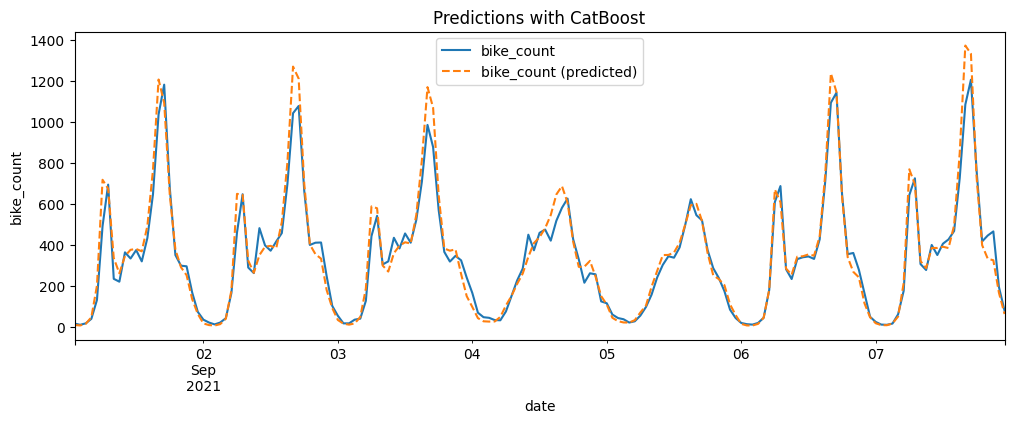

In [105]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with CatBoost")
ax.set_ylabel("bike_count")

In [106]:
mask = (

    (X_test["date"] > pd.to_datetime("2021/09/01"))
    & (X_test["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipcat.predict(X_test[mask])) - 1

In [107]:
df_viz = X_test.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipcat.predict(X_test[mask])) - 1
df_viz = (
        df_viz.groupby(pd.Grouper(key="date"))[["bike_count","bike_count (predicted)"]].sum().sort_index().reset_index()
    )

In [108]:
df_viz.head()

,date,bike_count,bike_count (predicted)
0,2021-09-01 01:00:00,231.0,154.39
1,2021-09-01 02:00:00,168.0,135.84
2,2021-09-01 03:00:00,340.0,314.43
3,2021-09-01 04:00:00,982.0,1091.65
4,2021-09-01 05:00:00,3866.0,4655.23


Text(0, 0.5, 'bike_count')

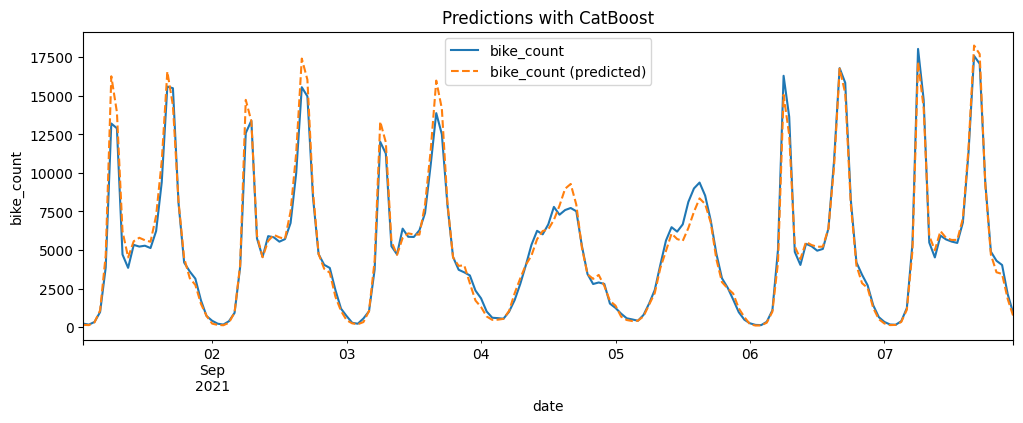

In [109]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with CatBoost")
ax.set_ylabel("bike_count")

In [110]:
df_viz = X_test.copy()
df_viz["bike_count"] = np.exp(y_test) - 1
df_viz["bike_count (predicted)"] = np.exp(pipcat.predict(X_test)) - 1
df_viz = (
        df_viz.groupby(pd.Grouper(freq="1h",key="date"))[["bike_count","bike_count (predicted)"]].sum().sort_index().reset_index()
    )
from matplotlib.dates import DateFormatter
mask = (X_test["counter_name"] == "90 Rue De Sèvres NE-SO"

)

df_viz1 = X_test.loc[mask].copy()
df_viz1["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz1["bike_count (predicted)"] = np.exp(pipcat.predict(X_test[mask])) - 1

df_viz1 = (
        df_viz1.groupby(pd.Grouper(freq="1h",key="date"))[["bike_count","bike_count (predicted)"]].sum().sort_index().reset_index()
    )


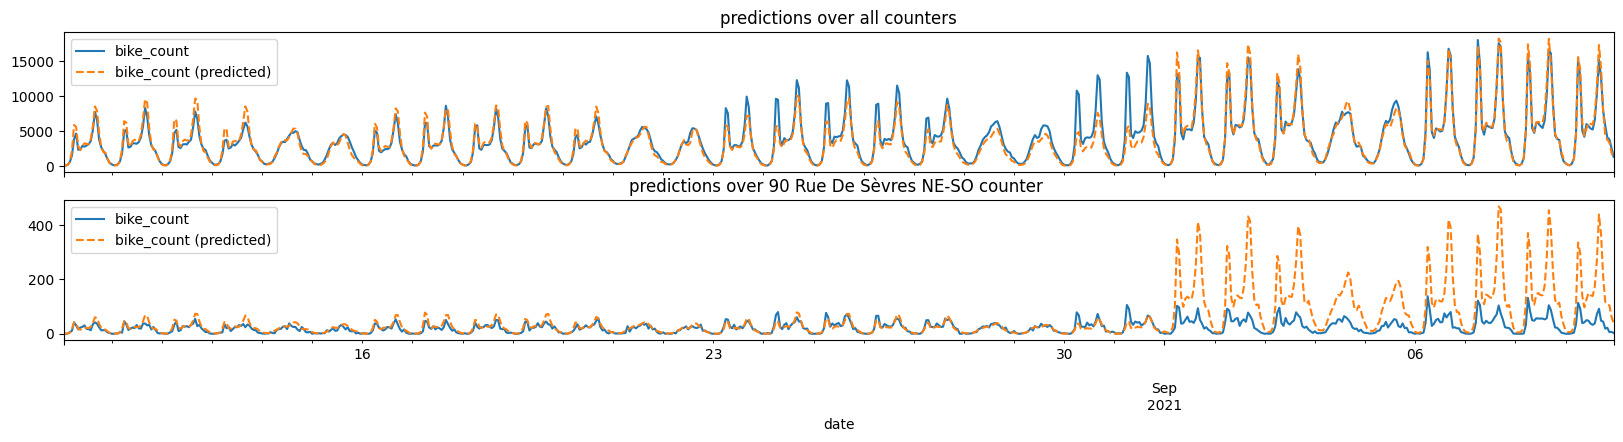

In [111]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(20, 4), sharex=True)

df_viz.plot(x="date", y="bike_count", ax=ax[0])
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax[0], ls="--")

ax[0].set_title("predictions over all counters")
ax[1].set_title("predictions over 90 Rue De Sèvres NE-SO counter ")
df_viz1.plot(x="date", y="bike_count", ax=ax[1])
df_viz1.plot(x="date", y="bike_count (predicted)", ax=ax[1], ls="--")
plt.savefig("general predictions",bbox_inches = "tight" )

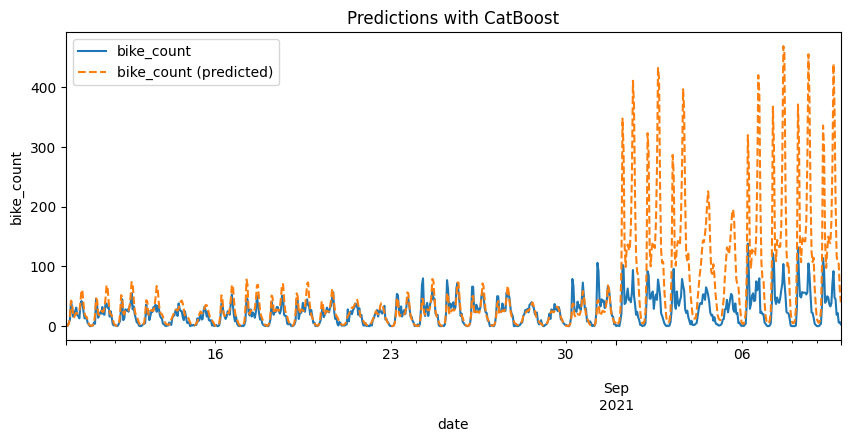

In [112]:
from matplotlib.dates import DateFormatter
mask = (X_test["counter_name"] == "90 Rue De Sèvres NE-SO"

)

df_viz1 = X_test.loc[mask].copy()
df_viz1["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz1["bike_count (predicted)"] = np.exp(pipcat.predict(X_test[mask])) - 1

df_viz1 = (
        df_viz1.groupby(pd.Grouper(freq="1h",key="date"))[["bike_count","bike_count (predicted)"]].sum().sort_index().reset_index()
    )

fig, ax = plt.subplots(figsize=(10, 4))

df_viz1.plot(x="date", y="bike_count", ax=ax)
df_viz1.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with CatBoost")
ax.set_ylabel("bike_count")
plt.savefig("sevres", bbox_inches = "tight")
#ax.set_xticks(df_viz["date"]..to_list())


In [113]:
df_accuracy = X_test.copy()
df_accuracy["bike_count"] = np.exp(y_test) - 1
df_accuracy["bike_count (predicted)"] = np.exp(pipcat.predict(X_test)) - 1

df_accuracy.head()

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,counter_technical_id,latitude,longitude,bike_count,bike_count (predicted)
409684,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2021-08-10 01:00:00,2018-12-07,Y2H19070373,48.84,2.33,2.0,1.56
419698,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2021-08-10 01:00:00,2018-12-07,Y2H19070373,48.84,2.33,2.0,1.36
95619,100036719-104036719,18 quai de l'Hôtel de Ville NO-SE,100036719,18 quai de l'Hôtel de Ville,2021-08-10 01:00:00,2017-07-12,Y2H19027732,48.85,2.36,2.0,1.18
106657,100036719-103036719,18 quai de l'Hôtel de Ville SE-NO,100036719,18 quai de l'Hôtel de Ville,2021-08-10 01:00:00,2017-07-12,Y2H19027732,48.85,2.36,4.0,1.55
883947,100063175-353277233,20 Avenue de Clichy NO-SE,100063175,20 Avenue de Clichy,2021-08-10 01:00:00,2020-07-22,Y2H20073268,48.89,2.33,6.0,4.99


In [114]:
df_accuracy = (
        df_accuracy.groupby(
            [pd.Grouper(key="counter_name"),
            pd.Grouper(key="date")]
                    )[["bike_count","bike_count (predicted)"]].sum().sort_index().reset_index()
    )

In [115]:
df_accuracy.head()

,counter_name,date,bike_count,bike_count (predicted)
0,152 boulevard du Montparnasse E-O,2021-08-10 01:00:00,2.0,1.56
1,152 boulevard du Montparnasse E-O,2021-08-10 02:00:00,2.0,1.14
2,152 boulevard du Montparnasse E-O,2021-08-10 03:00:00,2.0,2.65
3,152 boulevard du Montparnasse E-O,2021-08-10 04:00:00,18.0,8.25
4,152 boulevard du Montparnasse E-O,2021-08-10 05:00:00,25.0,29.63


In [116]:
df_accuracy_fin = df_accuracy.pivot_table(index=["counter_name","date"],values = ["bike_count", "bike_count (predicted)"])

In [117]:
df_accuracy_fin["RMSE"] = np.sqrt((df_accuracy_fin["bike_count"]-df_accuracy_fin["bike_count (predicted)"])**2)

In [118]:
df_accuracy_fin

bike_count  \
counter_name                      date                              
152 boulevard du Montparnasse E-O 2021-08-10 01:00:00         2.0   
                                  2021-08-10 02:00:00         2.0   
                                  2021-08-10 03:00:00         2.0   
                                  2021-08-10 04:00:00        18.0   
                                  2021-08-10 05:00:00        25.0   
...                                                           ...   
Voie Georges Pompidou SO-NE       2021-09-09 19:00:00        38.0   
                                  2021-09-09 20:00:00        34.0   
                                  2021-09-09 21:00:00        33.0   
                                  2021-09-09 22:00:00        25.0   
                                  2021-09-09 23:00:00         7.0   

                                                       bike_count (predicted)  \
counter_name                      date                                          
152 boulevard du Montparnasse E-O 2021-08-10 01:00:00                    1.56   
                                  2021-08-10 02:00:00                    1.14   
                                  2021-08-10 03:00:00                    2.65   
                                  2021-08-10 04:00:00                    8.25   
                                  2021-08-10 05:00:00                   29.63   
...                                                                       ...   
Voie Georges Pompidou SO-NE       2021-09-09 19:00:00                   50.71   
                                  2021-09-09 20:00:00                   39.80   
                                  2021-09-09 21:00:00                   34.68   
                                  2021-09-09 22:00:00                   20.61   
                                  2021-09-09 23:00:00                   13.30   

                                                        RMSE  
counter_name                      date                        
152 boulevard du Montparnasse E-O 2021-08-10 01:00:00   0.44  
                                  2021-08-10 02:00:00   0.86  
                                  2021-08-10 03:00:00   0.65  
                                  2021-08-10 04:00:00   9.75  
                                  2021-08-10 05:00:00   4.63  
...                                                      ...  
Voie Georges Pompidou SO-NE       2021-09-09 19:00:00  12.71  
                                  2021-09-09 20:00:00   5.80  
                                  2021-09-09 21:00:00   1.68  
                                  2021-09-09 22:00:00   4.39  
                                  2021-09-09 23:00:00   6.30  

[41608 rows x 3 columns]

In [119]:
df_accuracy_fin_counter = df_accuracy_fin.reset_index().groupby(pd.Grouper(key = "counter_name"))[["RMSE","bike_count"]].sum().sort_index().reset_index()


In [120]:
df_accuracy_fin_counter["accuracy_wrt_count"] = df_accuracy_fin_counter["RMSE"]/df_accuracy_fin_counter["bike_count"]

In [121]:
df_accuracy_fin_counter.head()

,counter_name,RMSE,bike_count,accuracy_wrt_count
0,152 boulevard du Montparnasse E-O,6757.68,32350.0,0.21
1,152 boulevard du Montparnasse O-E,6230.09,28597.0,0.22
2,18 quai de l'Hôtel de Ville NO-SE,5139.03,21098.0,0.24
3,18 quai de l'Hôtel de Ville SE-NO,6849.83,28422.0,0.24
4,20 Avenue de Clichy NO-SE,27950.24,69245.0,0.40


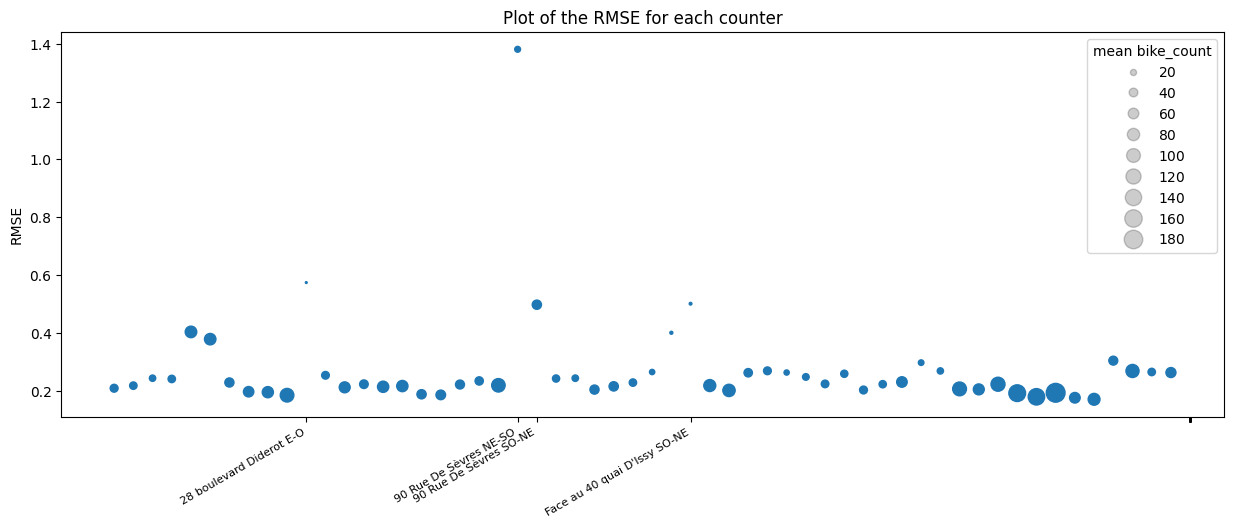

In [122]:
x_label =[]
for i in range(df_accuracy_fin_counter.shape[0]):
    if df_accuracy_fin_counter.loc[i,"accuracy_wrt_count"]<=0.45:
        x_label.append("")
    else:
        x_label.append(df_accuracy_fin_counter.loc[i,"counter_name"])


import seaborn as sns
fig, ax = plt.subplots(figsize = (15,5))
scatter = ax.scatter(df_accuracy_fin_counter["counter_name"], df_accuracy_fin_counter["accuracy_wrt_count"], s=df_accuracy_fin_counter["bike_count"]/1000)
ax.set_ylabel("RMSE")
ax.set_xticks(ticks=x_label)

ax.set_title("Plot of the RMSE for each counter")
plt.xticks(rotation=30, ha = "right", fontsize = 8)
# produce a legend with a cross section of sizes from the scatter
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.2)
ax.legend(handles, labels, loc="upper right", title="mean bike_count")
plt.savefig("RMSE_plot_vs_name", bbox_inches="tight")
plt.show()